In [0]:
#header for accessing google drive
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
!mkdir -p drive
!google-drive-ocamlfuse drive

# Clustering of Donald Trump's tweets


The goal of this project is identifying the topic of Donald Trump's tweets and grouping the tweets talking about a certain topic in the same category (cluster). The dataset consists of one year of tweets, from January 1st 2017 to January 1st 2018. The data can be downloaded from http://www.trumptwitterarchive.com/archive, and only the tweets by Trump were downloaded, excluding the retweets.

The tweets need to be encoded numerically before clustering. Two encodings were used, namely TF-IDF and doc2vec. We will compare several clustering algorithms, namely k-means, agglomerative clustering and DBSCAN.


## Header

In [0]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import re
import nltk
from nltk import FreqDist
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
nltk.download('stopwords')


from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

import gensim

!pip install hypertools
import hypertools as hyp

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

from sklearn.model_selection import ParameterSampler
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score

## Loading the dataset

The first thing to do is loading the dataset and counting the number of tweets:

In [3]:
dataset_path = "/content/drive/trump/tweets.xlsx"
dataset = pd.read_excel(dataset_path, encoding = 'latin1')
print('Number of tweets: '+str(dataset.shape[0]))

Number of tweets: 2281


We can have a look at the text of the tweets:

In [5]:
pd.options.display.max_colwidth = 100
print(dataset.head())

                                                                                                  text
0  As our Country rapidly grows stronger and smarter I want to wish all of my friends supporters en...
1  Iran the Number One State of Sponsored Terror with numerous violations of Human Rights occurring...
2  What a year it’s been and we're just getting started. Together we are MAKING AMERICA GREAT AGAIN...
3  My deepest condolences to the victims of the terrible shooting in Douglas County @DCSheriff and ...
4  Why would smart voters want to put Democrats in Congress in 2018 Election when their policies wi...


## **Preprocessing**


For clustering the tweets according to their content we only need the plain text without punctuation and other symbols. As text preprocessing we will remove the URLs, numbers, punctuation and other symbols, as well as transforming the uppercase to lowercase. It was decided to keep the hashtags since they might constitute a valuable information for clustering.

After cleaning the data we can divide each tweet into works using a tokenizer. We will also remove stop words, being these common words with little meaning (the, a, I, etc):


In [8]:
tok = WordPunctTokenizer()

def filtering(text,stop_words):
  return [w for w in text if w not in set(stop_words)]
  
def tweet_cleaner(text,stop_words):
    text = re.sub(r"http\S+", "", text).strip()
    text = re.sub("[^a-zA-Z]", " ", text).lower()
    text = tok.tokenize(text)
    return filtering(text,stop_words)
  
dataset['processed'] = dataset.apply(lambda row: tweet_cleaner(row['text'],stopwords.words("english")), axis=1) 
print(dataset['processed'].head())

0    [country, rapidly, grows, stronger, smarter, want, wish, friends, supporters, enemies, haters, e...
1    [iran, number, one, state, sponsored, terror, numerous, violations, human, rights, occurring, ho...
2                           [year, getting, started, together, making, america, great, happy, new, year]
3    [deepest, condolences, victims, terrible, shooting, douglas, county, dcsheriff, families, love, ...
4    [would, smart, voters, want, put, democrats, congress, election, policies, totally, kill, great,...
Name: processed, dtype: object


### Word frequency 

After removing the stop words it is interesting to visualize the word frequency calculated as the number of occurences of the most common words:

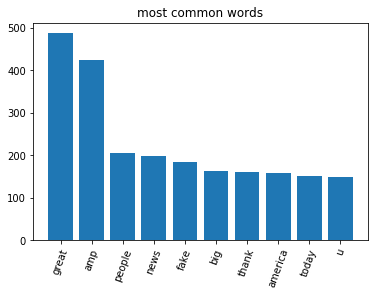

In [9]:
def plot_most_common(fdist,n,title='most common words'):
  most_common = fdist.most_common(n)

  words = [t[0] for t in most_common]
  freq = [t[1] for t in most_common]

  fig,ax = plt.subplots()
  ax.bar(words,freq)
  ax.set_title(title)
  plt.xticks(rotation=70)
  return

fdist = FreqDist([item for sublist in dataset['processed'].tolist() for item in sublist])
plot_most_common(fdist,10)
 

It is observed that there are certain words particular to Mr Trump's context that are still very common amongst the cleaned tweets. Some of these words can be removed as well.


In [0]:
#words to remove
common_words = ['great','amp','u','look','thank','w','america','american','president','people','country'
               'get','today','must','go','much','want','come','would','big','make']

dataset['filtered'] = dataset.apply(lambda row: filtering(row['processed'],common_words), axis=1)
dataset['filtered'] = dataset.apply(lambda row: ' '.join(row['filtered']),axis=1)
dataset['filtered_tok'] = dataset.apply(lambda row: tok.tokenize(row['filtered']),axis=1)

After removing these words we can inspect again the word frequency.

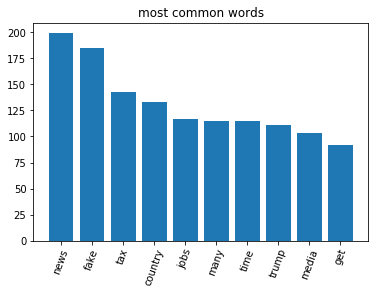

In [12]:
fdist = FreqDist([item for sublist in dataset['filtered_tok'].tolist() for item in sublist])
plot_most_common(fdist,10)

## **Encoding**

Text data needs to be transformed into numerical values before applying the clustering algorithms. Two approaches will be considered, TF-IDF and doc2vec. 

In [0]:
data = dataset['filtered'].tolist()

###TF-IDF

[TF-IDF](https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction) stands for term frequency-inverse document frequency, and it is a feature extraction method for text. This method yields a very high dimensional vector for each document, tweets in this case. Since the dimension of the vectors is in the orders of tens of thousands, dimensionality reduction might be handy. Truncated Singular Value Decomposition will be applied only keeping the 50 eigenvectors with larges eigenvalues. Therefore the tweets will be represented as 50 dimensional vectors. The resulting data will be normalized between 0 and 1.



In [0]:
def tfidf_enc(data,n_components=50):
  tfidf = TfidfVectorizer()
  svd = TruncatedSVD(n_components=n_components)
  normalizer = Normalizer()
  encoder = make_pipeline(tfidf,svd,normalizer)

  enc_data = encoder.fit_transform(data)
  return enc_data

n_components=50
enc_data = tfidf_enc(data,n_components)

The data points can be visualized by using a projection into a low dimensional space. We will use [t-SNE](http://lvdmaaten.github.io/publications/papers/JMLR_2008.pdf) since it is demonstrated to yield good representation of high dimensional datasets. 


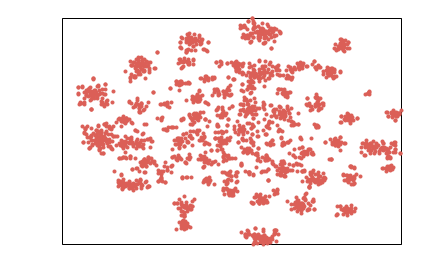

In [0]:
#2D visualization 
hyp.plot(enc_data, '.', reduce='TSNE', ndims=2)

It can be observed that the two dimensional representation already presents some clustering structure.

### **Doc2vec**

[doc2vec](https://cs.stanford.edu/~quocle/paragraph_vector.pdf) is a deep learning-based method for finding dense vector representation of documents. A deep learning model is trained for predicting the next word for a given sequence of words of the original text corpus. Once the model is trained it outputs vectors of a specified dimension for each tweet. The number of dimensions in this case will be set to 50.



In [0]:
def doc2vec_enc(data,vector_size=50):
  #tag tweets
  train_corpus = []
  i = 0
  for tweet in data:
    train_corpus.append(gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(tweet), [i]))
    i += 1

  #training the model
  model = gensim.models.doc2vec.Doc2Vec(vector_size=vector_size, min_count=2, epochs=20)
  model.build_vocab(train_corpus)
  model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

  #applying doc2vec to the dataset
  enc_data = np.zeros((0,vector_size))
  for doc_id in range(len(train_corpus)):
    v_tweet = model.infer_vector(train_corpus[doc_id].words)
    enc_data = np.vstack((enc_data,v_tweet))

  return enc_data

vector_size = 50
enc_data = doc2vec_enc(data,vector_size)

The resulting vectors can be visualized in two dimensions:

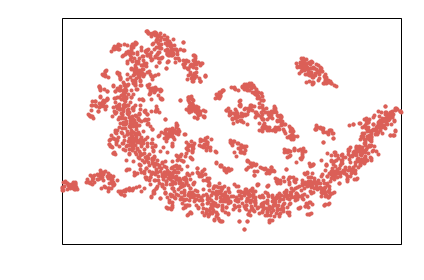

In [0]:
#2D visualization 
hyp.plot(enc_data, '.', reduce='TSNE', ndims=2)

The structure of the representation by doc2vec seems different from TF-IDF, so it is expected that the clustering results also differ.

# **Clustering**

The goal of clustering is to divide the data space into groups containing data points with similar features. There are plenty of clustering algorithms, and in this project k-means, agglomerative clustering and DBSCAN will be considered.

Clustering is an unsupervised learning technique, so there are not such a thing as labels. A question of interest is how to evaluate the performance of the clustering method, and we will use the [Silhouette score](https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient) . The silhouette score is a metric which evaluates how good a data point belongs to a cluster. It will be +1 if the point is perfectly clustered and -1 if the point should belong to a different cluster. 

The silhouette score can be computed for each instance of the dataset and can be plotted. The following code for plotting the silhouette score was obtained from [here](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py)





In [0]:
def plot_silhouette(n_clusters,cluster_labels,vectors):
  
  fig, ax1 = plt.subplots(1, 1)
  fig.set_size_inches(18, 7)
  ax1.set_xlim([-0.1, 1])
  ax1.set_ylim([0, vectors.shape[0] + (n_clusters + 1) * 10])
  sample_silhouette_values = silhouette_samples(vectors, cluster_labels)
  silhouette_avg = silhouette_score(vectors, cluster_labels)
  y_lower = 10
  for i in range(n_clusters):
      ith_cluster_silhouette_values = \
          sample_silhouette_values[cluster_labels == i]

      ith_cluster_silhouette_values.sort()
      size_cluster_i = ith_cluster_silhouette_values.shape[0]
      y_upper = y_lower + size_cluster_i
      color = cm.nipy_spectral(float(i) / n_clusters)
      ax1.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

      ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
      y_lower = y_upper + 10 

  ax1.set_title("The silhouette plot for the various clusters.")
  ax1.set_xlabel("The silhouette coefficient values")
  ax1.set_ylabel("Cluster label")
  ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
  ax1.set_yticks([])  # Clear the yaxis labels / ticks
  ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
  return

Although a clustering algorithm will automatically group similar data points into clusters, the number of clusters is usually a hyperparameter that needs to be set. This is the case for k-means and agglomerative clustering.


The following function performs clustering for several number of clusters, computes the average silhouette score and plots the results. It does so for both TF-IDF and doc2vec encodings:

In [0]:
def loop_clusters(range_clus,c,data,n_components=50):

  sil_tf = []
  sil_d2v = []
  for n_clusters in range_clus:

    if c == 'km':
      clusterer = KMeans(n_clusters=n_clusters,n_init=10)
    elif c == 'agg':
      clusterer = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
    
    tf_data = tfidf_enc(data,n_components)
    labels_tf = clusterer.fit_predict(tf_data)
    sil_tf.append(silhouette_score(tf_data, labels_tf))
    
    d2v_data = doc2vec_enc(data,n_components)
    labels_d2v = clusterer.fit_predict(d2v_data)
    sil_d2v.append(silhouette_score(d2v_data, labels_d2v))

  fig,ax = plt.subplots(1,2,figsize=(10,4))  
  ax[0].plot(range_clus,sil_tf)
  ax[0].set_title('TF-IDF')
  ax[0].set_xlabel('n_clusters')
  ax[0].set_ylabel('silhouette score')
  
  ax[1].plot(range_clus,sil_d2v)
  ax[1].set_title('doc2vec')
  ax[1].set_xlabel('n_clusters')
  ax[1].set_ylabel('silhouette score')
  
  return

The silhouette score constitutes a formal evaluation metric for the clustering algorithm. We can also assess the performance of the clustering by examining the word frequency of each cluster. The following function plots the word frequency of each cluster.


In [0]:
#frequency of predictions
def plot_frequency_clusters(n_clusters,cluster_labels,dataset,n=10,figsize=(10,40)):
  
  fig,ax = plt.subplots(int(n_clusters/2)+n_clusters%2,2,figsize=figsize)
 
  for k in range(n_clusters):
    ind = np.where(cluster_labels==k)
    pred_clus = dataset.iloc[ind]
    pred_clus = pred_clus.apply(lambda row: tweet_cleaner(row,stopwords.words("english"))) 
    pred_clus = pred_clus.apply(lambda row: filtering(row,common_words))
    
    fdist = FreqDist([item for sublist in pred_clus.tolist() for item in sublist])
    most_common = fdist.most_common(n)
    
    words = [t[0] for t in most_common]
    freq = [t[1] for t in most_common]

    
    ax[int(k/2),k%2].bar(words,freq)
    ax[int(k/2),k%2].set_title('Cluster {}'.format(k))
    for tick in ax[int(k/2),k%2].get_xticklabels():
        tick.set_rotation(45)
    plt.tight_layout()

  return

## **k-means clustering**

[k-means](https://scikit-learn.org/stable/modules/clustering.html#k-means) clustering is a classical and simple clustering algorithm which takes the number of clusters as a hyperparameter. We can loop over the number of clusters and run k-means for each number of clusters. Then the performance of the algorithm can be assessed by the average silhouette score

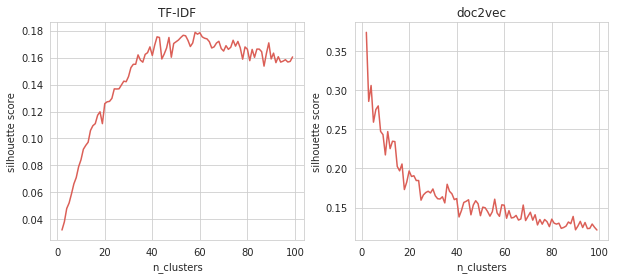

In [0]:
loop_clusters(range(2,100),'km',data,n_components=50)

### **Model evaluation TF-IDF**

Based on the results of the previous section we can choose a fixed number of clusters and analyze the performance of the algorithm. 

The clustered data can be visualized and the average silhouette score computed:

Silhouette score:  0.148588778977799


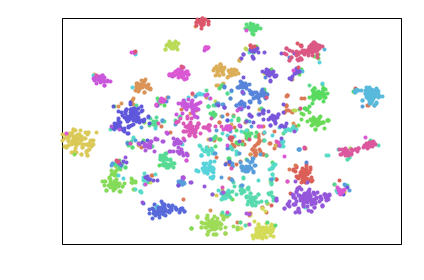

In [19]:
enc_data = tfidf_enc(data,50)
n_clusters = 30
clusterer = KMeans(n_clusters)
labels = clusterer.fit_predict(enc_data)
print('Silhouette score: ',silhouette_score(enc_data, labels))

#2D visualization 
hyp.plot(enc_data, '.', reduce='TSNE',hue=labels, ndims=2)

We also plot the silhouette score for each tweet:

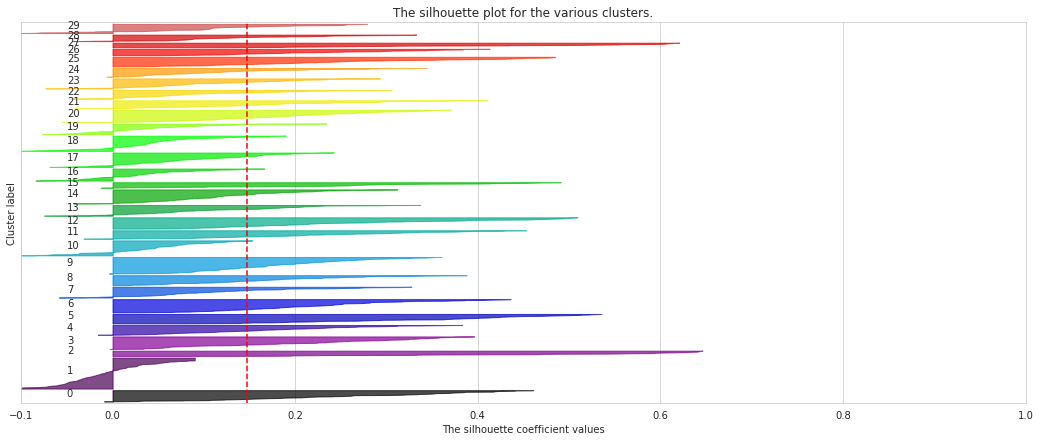

In [0]:
plot_silhouette(n_clusters,labels,enc_data)

A more insightful visualization is the word frequency of each cluster:

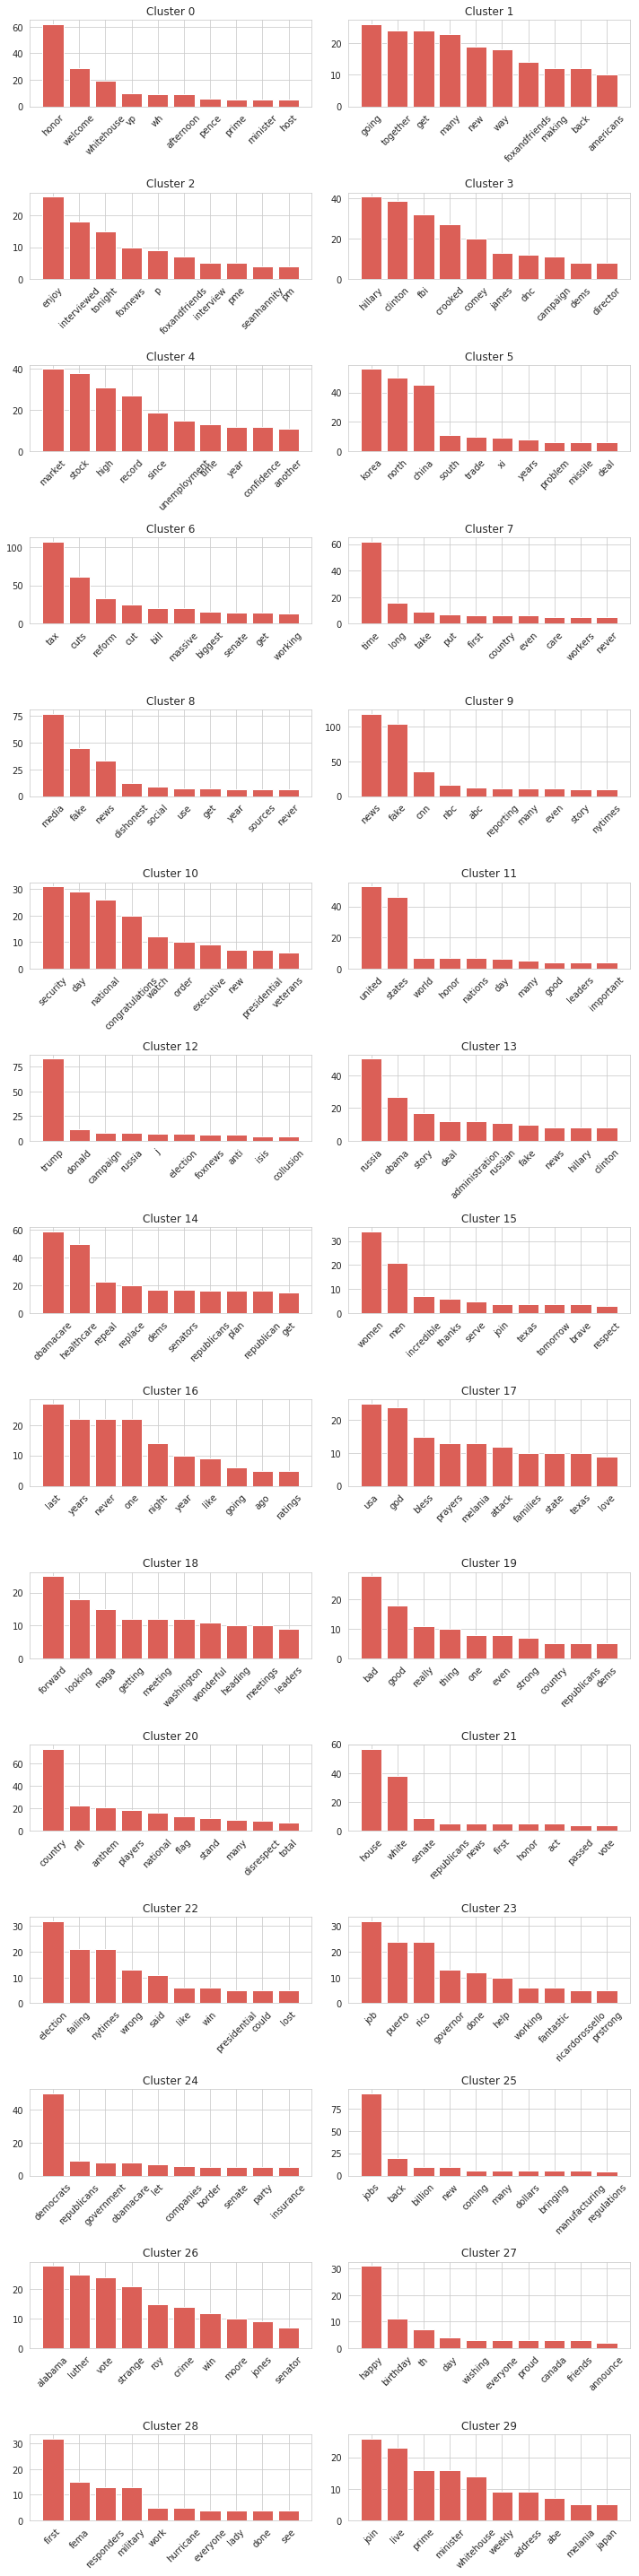

In [0]:
plot_frequency_clusters(n_clusters,labels,dataset['text'],n=10,figsize=(10,40))

It is remarkable that k-means clustering together with the TF-IDF encoding is able to clearly separate the tweets into easy recognizable clusters talking about:  

*   Stock market
*   Healthcare, Obamacare
*   Tax cuts
*   Fake news
*   Asian politics
*   NFL anthem issue

amongst others.

### **Model evaluation doc2vec**

For the doc2vec encoding we will repeat the same experiment with the same number of clusters. 

Silhouette score:  0.1662846369557077


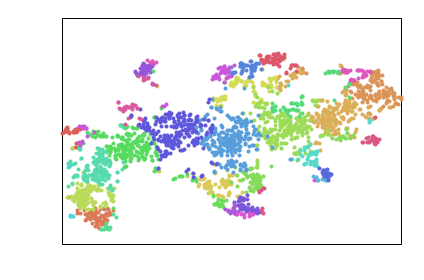

In [20]:
n_components=50
enc_data = doc2vec_enc(data,n_components)

n_clusters = 30
clusterer = KMeans(n_clusters=n_clusters)
labels = clusterer.fit_predict(enc_data)
print('Silhouette score: ',silhouette_score(enc_data, labels))

#2D visualization 
hyp.plot(enc_data, '.', reduce='TSNE',hue=labels, ndims=2)

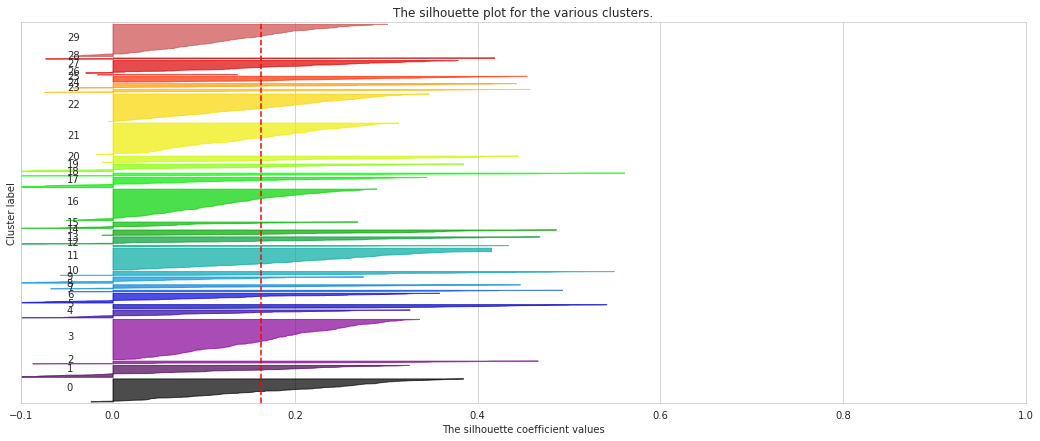

In [0]:
plot_silhouette(n_clusters,labels,enc_data)

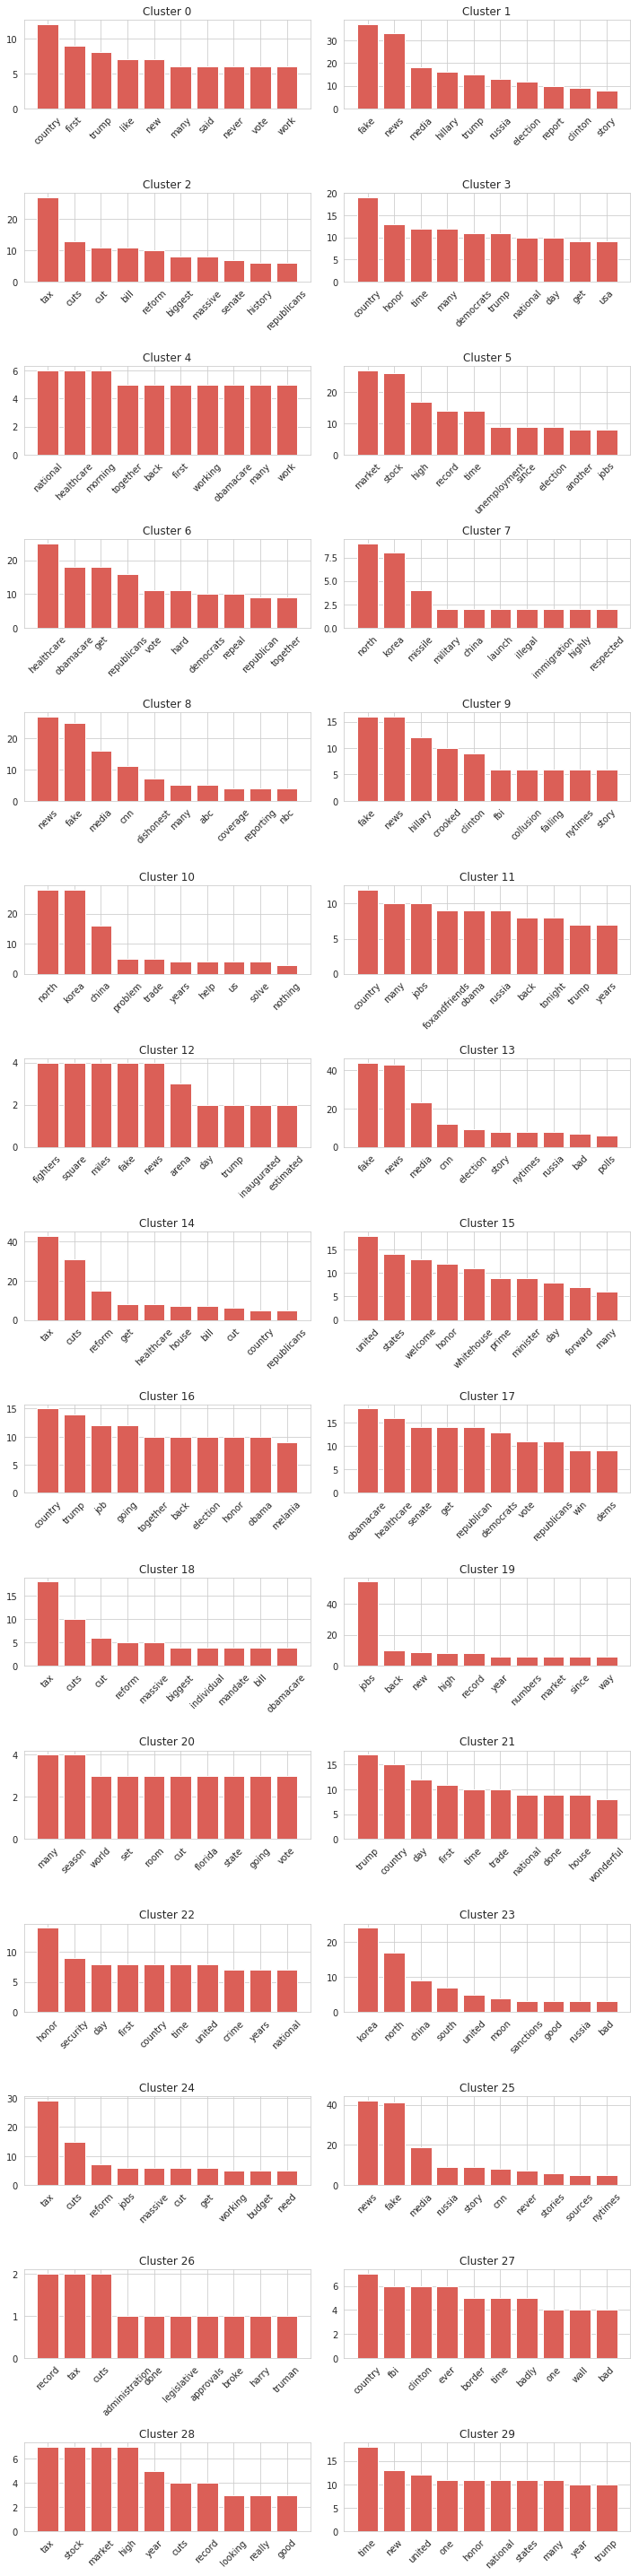

In [0]:
plot_frequency_clusters(n_clusters,labels,dataset['text'],n=10,figsize=(10,40))

Even though the representation resulting from TF-IDF and doc2vec are quite different, the resulting clusters have a similar word frequency.

## **Agglomerative clustering**

[Agglomerative clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering) belongs to the framework of [hierarchical clustering](https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering). When initializing the algorithm each tweet is considered as a cluster. The clusters are merged according to a certain criterion, in this case minimizing the sum of squared differences within all clusters.

For this algorithm the number of clusters is a hyperparameter as well. As with k-means we will compute the average silhouette score for each number of clusters:


"\nn_components=50\nenc_data = tfidf_enc(data,n_components)\nloop_clusters(range(6,50),'agg',enc_data,'tfidf')\n\nn_components=50\nenc_data = doc2vec_enc(data,n_components)\nloop_clusters(range(6,50),'agg',enc_data,'doc2vec')\n\n"

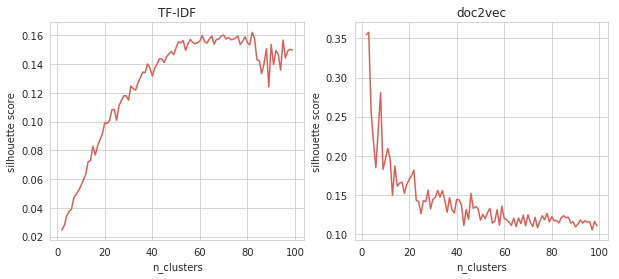

In [0]:
loop_clusters(range(2,100),'agg',data,n_components=50)

### **Model evaluation TF-IDF**

After setting the number of clusters to 30 we can calculate the average silhouette score and we can visualize the clustering with TF-IDF encoding:

Silhouette score:  0.11941811085313263


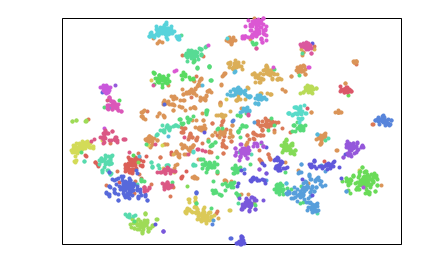

In [21]:
enc_data = tfidf_enc(data,n_components=50)
n_clusters = 30
clusterer = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
labels = clusterer.fit_predict(enc_data)
print('Silhouette score: ',silhouette_score(enc_data, labels))

#2D visualization 
hyp.plot(enc_data, '.', reduce='TSNE',hue=labels, ndims=2)

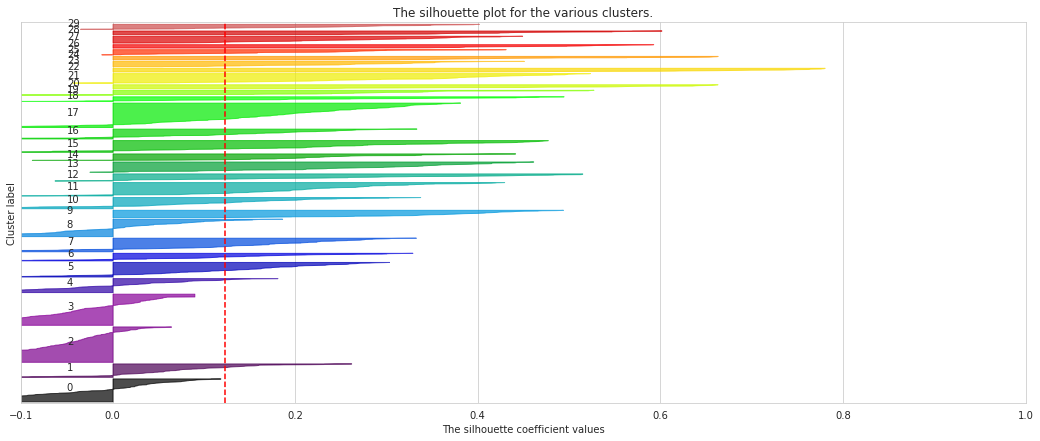

In [0]:
plot_silhouette(n_clusters,labels,enc_data)

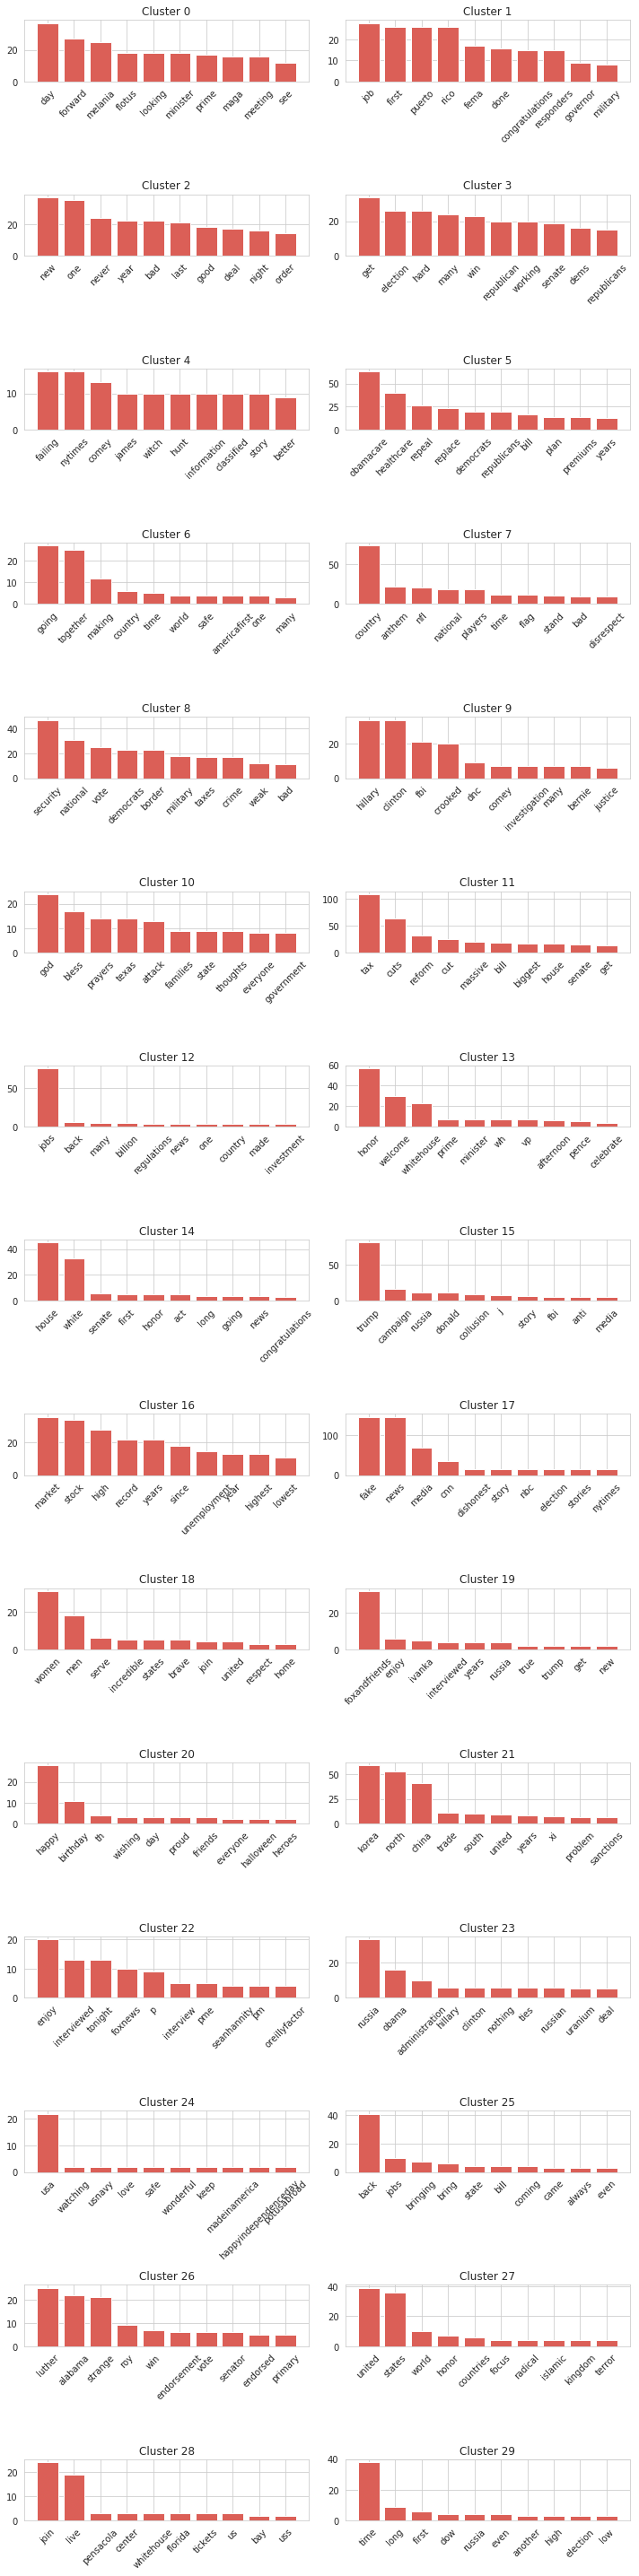

In [0]:
plot_frequency_clusters(n_clusters,labels,dataset['text'],n=10,figsize=(10,40))

### **Model evaluation doc2vec**

Fixing the number of clusters we can assess the clustering with the average silhouette score:

Silhouette score:  0.138336017085878


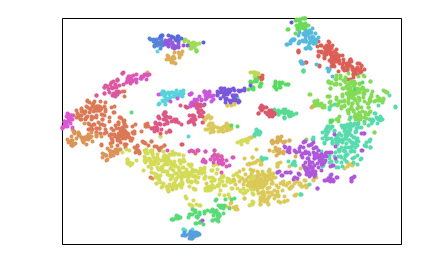

In [0]:
enc_data = doc2vec_enc(data,50)
n_clusters = 30
clusterer = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
labels = clusterer.fit_predict(enc_data)
print('Silhouette score: ',silhouette_score(enc_data, labels))

#2D visualization 
hyp.plot(enc_data, '.', reduce='TSNE',hue=labels, ndims=2)

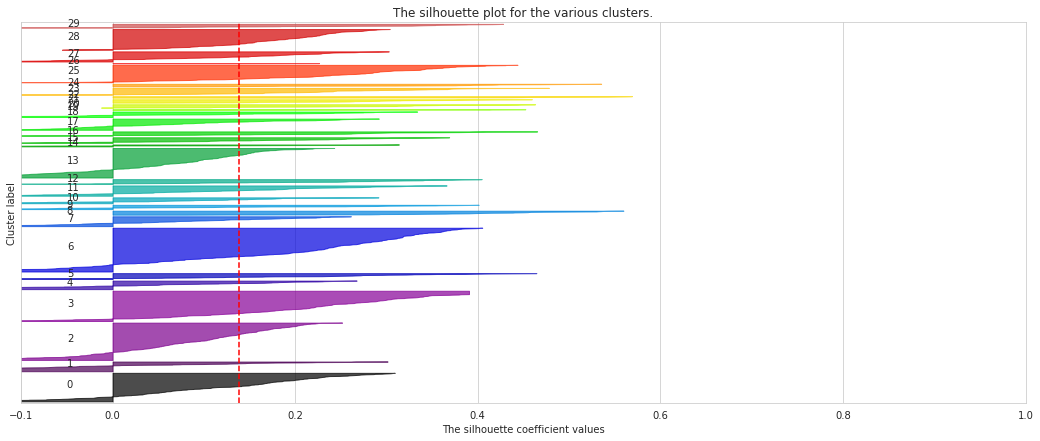

In [0]:
plot_silhouette(n_clusters,labels,enc_data)

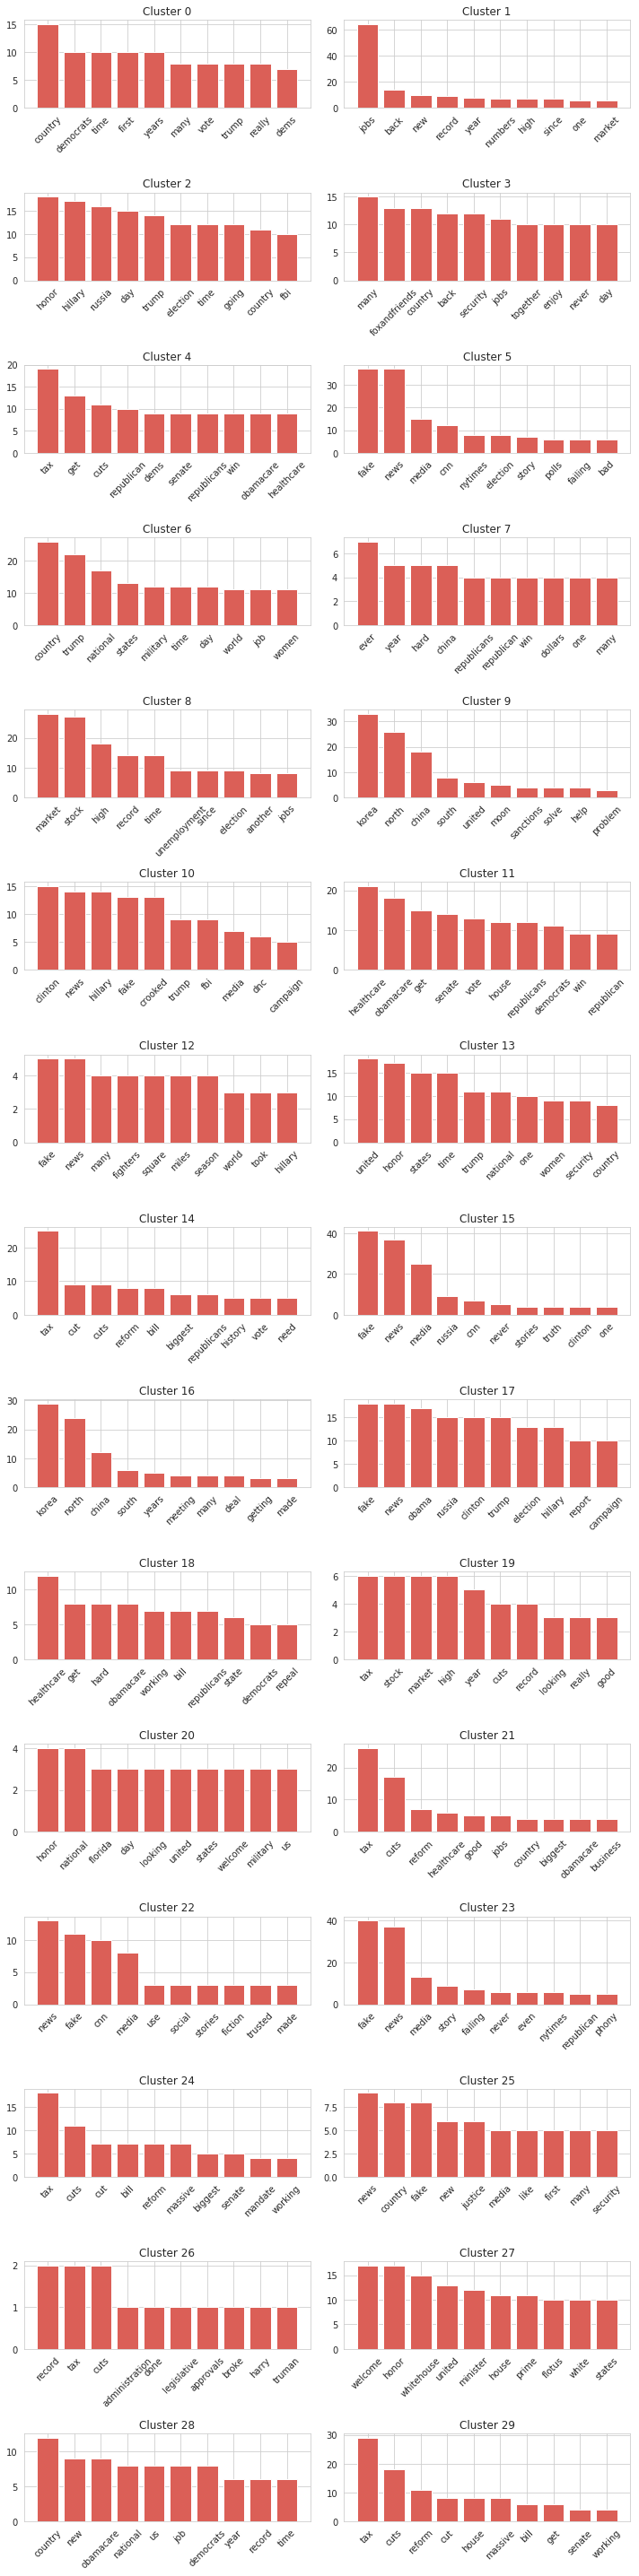

In [0]:
plot_frequency_clusters(n_clusters,labels,dataset['text'],n=10,figsize=(10,40))

## DBSCAN

[DBSCAN](https://scikit-learn.org/stable/modules/clustering.html#dbscan) is a clustering technique which takes a density-based approach. It separates the data into valid and noise data. Once this distinction has been made it clusters the valid data. 

DBSCAN automatically finds the optimal number of clusters, so the number of clusters is not a hyperparameter in this case. This algorithm has two hyperparamters: eps and min_samples. eps is the maximum distance between two data points for being considered in the neighbourhood of each other and min_samples is the number of data points for considering a group of data points as a cluster.


DBSCAN is very sensitive to these hyperparameters and finding the right values is problem-dependent and difficult. Random search over different values of eps and min_samples will be performed.




###Random search TF-IDF

For most of the configurations of eps and min_samples only a small number of tweets will remain as valid data, being most of the tweets labeled as noise. We will filter the configurations which yield a reasonable number of noise points as well as a reasonable number of clusters:

In [0]:
enc_data = tfidf_enc(data,n_components=50)
param_grid = {'eps':np.logspace(-2,0,num=50,base=10),'min_samples':range(1,20)}
grid = ParameterSampler(param_grid,n_iter = 100)

for params in grid:
  #clustering
  db = DBSCAN(eps=params['eps'], min_samples=params['min_samples']).fit(enc_data)
  labels = db.labels_
  n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
  n_noise = list(labels).count(-1)
  #remove noise points
  ind = np.where(labels!=-1)
  pos_labels = labels[ind]
  pos_data = enc_data[ind]
  #output metrics
  if n_clusters > 10 and n_clusters < 100 and n_noise < 2000:
    sil_sc = silhouette_score(pos_data, pos_labels)
    if sil_sc > 0:
      print(params)
      print('n_clusters: {}'.format(n_clusters))
      print('noise: {}'.format(n_noise))
      print('Silhouette score: {}'.format(sil_sc))
      print('\n')
    

{'min_samples': 13, 'eps': 0.6866488450042998}
n_clusters: 28
noise: 1317
Silhouette score: 0.2061019699036119


{'min_samples': 10, 'eps': 0.6866488450042998}
n_clusters: 33
noise: 1136
Silhouette score: 0.11234803569353821


{'min_samples': 17, 'eps': 0.7543120063354615}
n_clusters: 27
noise: 1028
Silhouette score: 0.08871453927981936


{'min_samples': 7, 'eps': 0.6250551925273969}
n_clusters: 43
noise: 1314
Silhouette score: 0.26796082813408584


{'min_samples': 5, 'eps': 0.5689866029018296}
n_clusters: 53
noise: 1461
Silhouette score: 0.3421368933223926


{'min_samples': 7, 'eps': 0.5689866029018296}
n_clusters: 41
noise: 1581
Silhouette score: 0.380144123703005




### **Model evaluation TF-IDF**

Now we can select one of the configurations from the previous section to evaluate DBSCAN:

Estimated number of clusters: 36
Estimated number of noise points: 1619


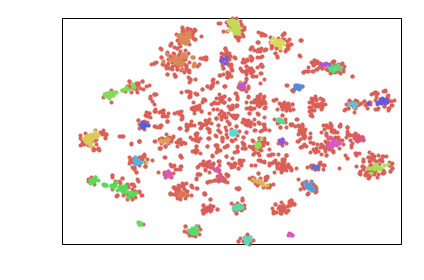

In [0]:
#clustering
enc_data = tfidf_enc(data,n_components=50)
db = DBSCAN(eps=0.5689866029018296, min_samples=7).fit(enc_data)
labels = db.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)
print('Number of clusters: %d' % n_clusters)
print('Number of noise points: %d' % n_noise)

#2D visualization 
hyp.plot(enc_data, '.', reduce='TSNE',hue=labels, ndims=2)

We observe that only those data points corresponding to very dense areas are considered as valid points, the rest of the data being considered as noise. After removing the noise data we can calculate the silhouette score and visualize the clustered valid points.

Silhouette score:  0.37110240556714147


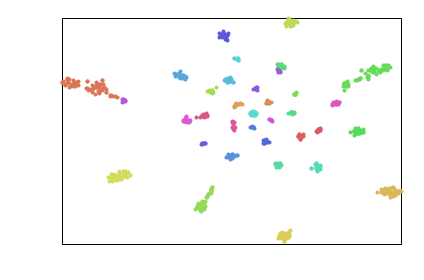

In [0]:
#remove noise points
ind = np.where(labels!=-1)
pos_labels = labels[ind]
pos_data = enc_data[ind]
print('Silhouette score: ',silhouette_score(pos_data, pos_labels))

#2D visualization 
hyp.plot(pos_data, '.', reduce='TSNE',hue=pos_labels, ndims=2)

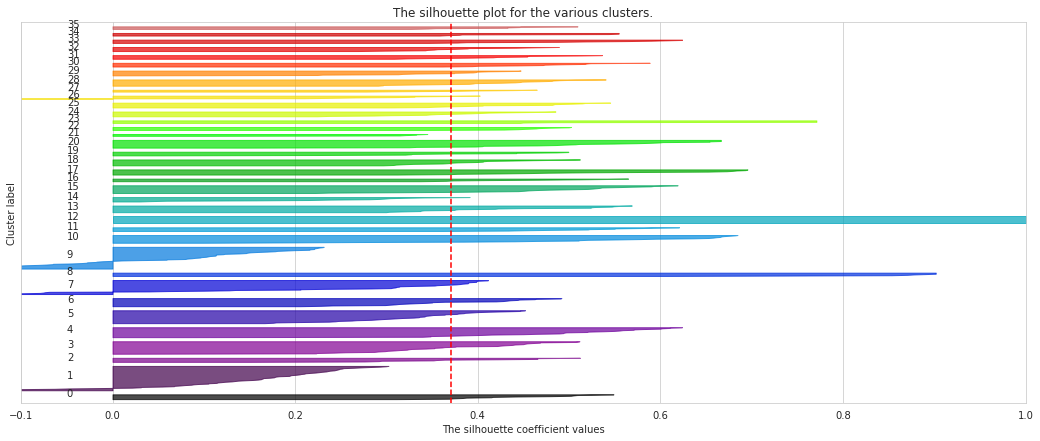

In [0]:
plot_silhouette(n_clusters,pos_labels,pos_data)

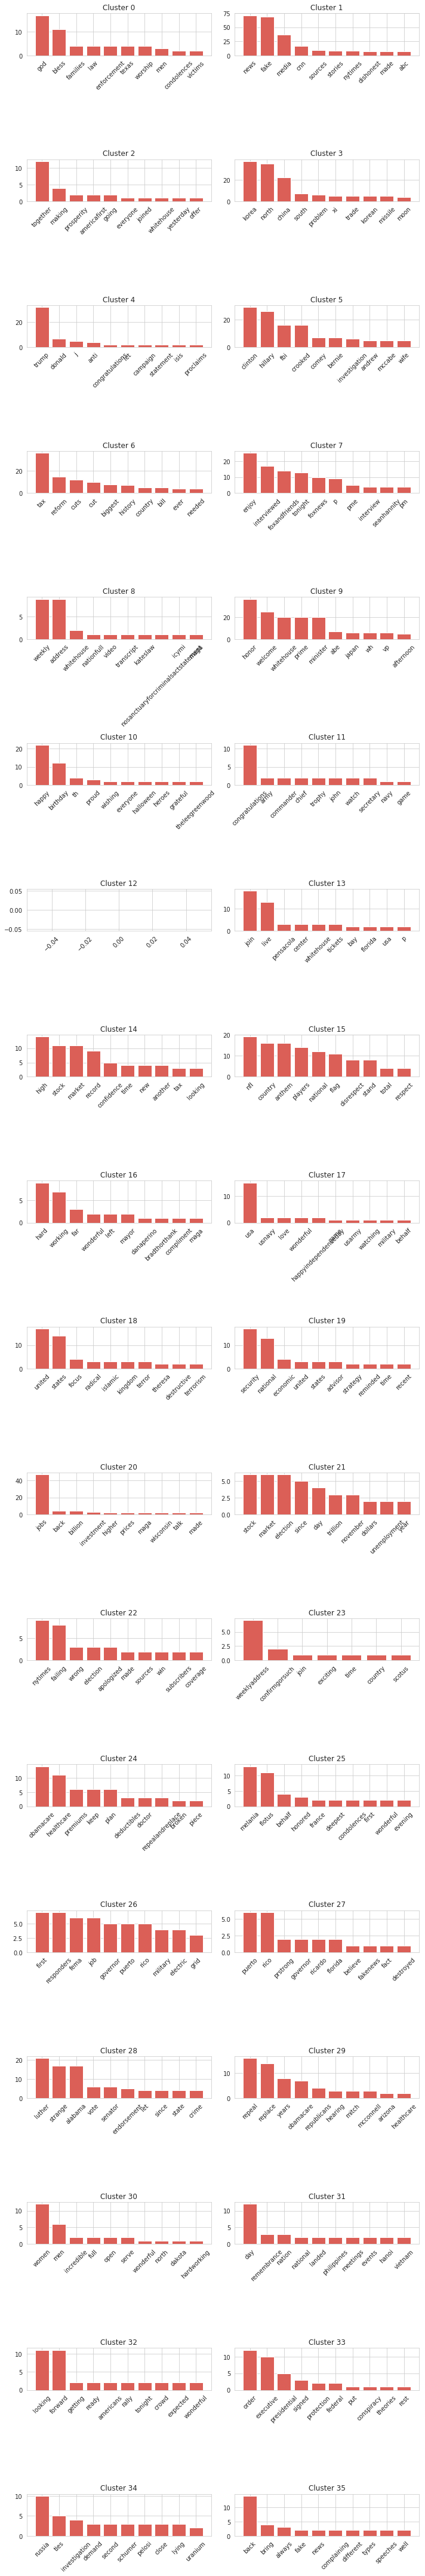

In [0]:
tweets = dataset['text'].iloc[ind]
tweets = tweets.reset_index(drop=True)
plot_frequency_clusters(n_clusters,pos_labels,tweets,n=10,figsize=(10,60))

The word frequency of the resulting clusters is similar to the previous approaches.

### **Random search doc2vec**

The hyperparameter search of the last section needs to be repeated for the doc2vec encoding, and only those configurations with a relatively small number of noise points will be kept:

In [0]:
enc_data = doc2vec_enc(data,50)
param_grid = {'eps':np.linspace(0.05,0.06,200),
              'min_samples':range(2,15),
              'leaf_size':[1,5,10,20,30,40,50]}

grid = ParameterSampler(param_grid,n_iter = 400)

for params in grid:
  #clustering
  db = DBSCAN(eps=params['eps'], min_samples=params['min_samples'],leaf_size=params['leaf_size']).fit(enc_data)
  labels = db.labels_
  n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
  n_noise = list(labels).count(-1)
  #remove noise points
  ind = np.where(labels!=-1)
  pos_labels = labels[ind]
  pos_data = enc_data[ind]
  #output metrics
  if n_clusters > 10 and n_clusters < 50 and n_noise < 2000:
    sil_sc = silhouette_score(pos_data, pos_labels)
    if sil_sc > 0:
      print(params)
      print('n_clusters: {}'.format(n_clusters))
      print('noise: {}'.format(n_noise))
      print('Silhouette score: {}'.format(sil_sc))
      print('\n')


{'min_samples': 3, 'leaf_size': 5, 'eps': 0.05733668341708543}
n_clusters: 18
noise: 1944
Silhouette score: 0.11825168302194031


{'min_samples': 4, 'leaf_size': 1, 'eps': 0.0578391959798995}
n_clusters: 12
noise: 1967
Silhouette score: 0.11512523834043531


{'min_samples': 3, 'leaf_size': 30, 'eps': 0.05763819095477387}
n_clusters: 17
noise: 1925
Silhouette score: 0.16972999435986957


{'min_samples': 3, 'leaf_size': 40, 'eps': 0.057236180904522614}
n_clusters: 18
noise: 1948
Silhouette score: 0.1188301382485302


{'min_samples': 3, 'leaf_size': 50, 'eps': 0.057236180904522614}
n_clusters: 18
noise: 1948
Silhouette score: 0.1188301382485302


{'min_samples': 4, 'leaf_size': 20, 'eps': 0.05814070351758794}
n_clusters: 13
noise: 1951
Silhouette score: 0.11350949627421118


{'min_samples': 4, 'leaf_size': 30, 'eps': 0.057386934673366835}
n_clusters: 11
noise: 1993
Silhouette score: 0.2436953542660005




### **Model evaluation doc2vec**

Estimated number of clusters: 11
Estimated number of noise points: 2012


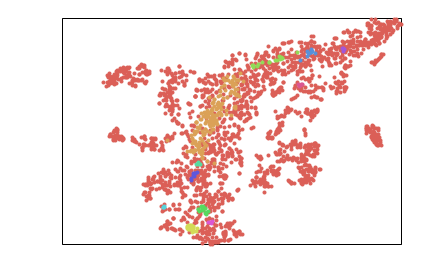

In [0]:
#clustering
enc_data = doc2vec_enc(data,50)
db = DBSCAN(eps=0.057386934673366835, min_samples=4,leaf_size=30).fit(enc_data)
labels = db.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)
print('Number of clusters: {}'.format(n_clusters))
print('Number of noise points: {}'.format(n_noise))

#2D visualization 
hyp.plot(enc_data, '.', reduce='TSNE',hue=labels, ndims=2)

It seems that the doc2vec representation yields a less dense representation than TF-IDF and DBSCAN is not able to build as many clusters as with TF-IDF.

Silhouette score:  0.23804292317981363


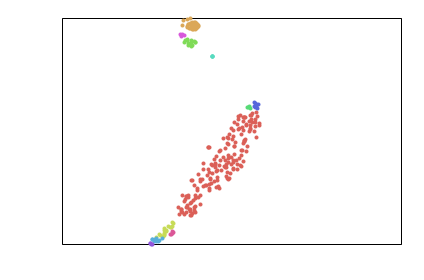

In [0]:
#remove noise points
ind = np.where(labels!=-1)
pos_labels = labels[ind]
pos_data = enc_data[ind]
print('Silhouette score: ',silhouette_score(pos_data, pos_labels))

#2D visualization 
hyp.plot(pos_data, '.', reduce='TSNE',hue=pos_labels, ndims=2)

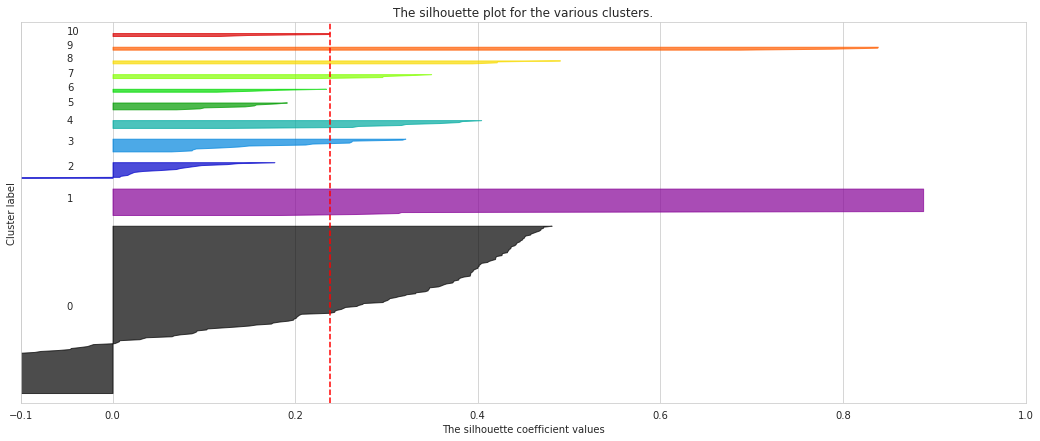

In [0]:
plot_silhouette(n_clusters,pos_labels,pos_data)

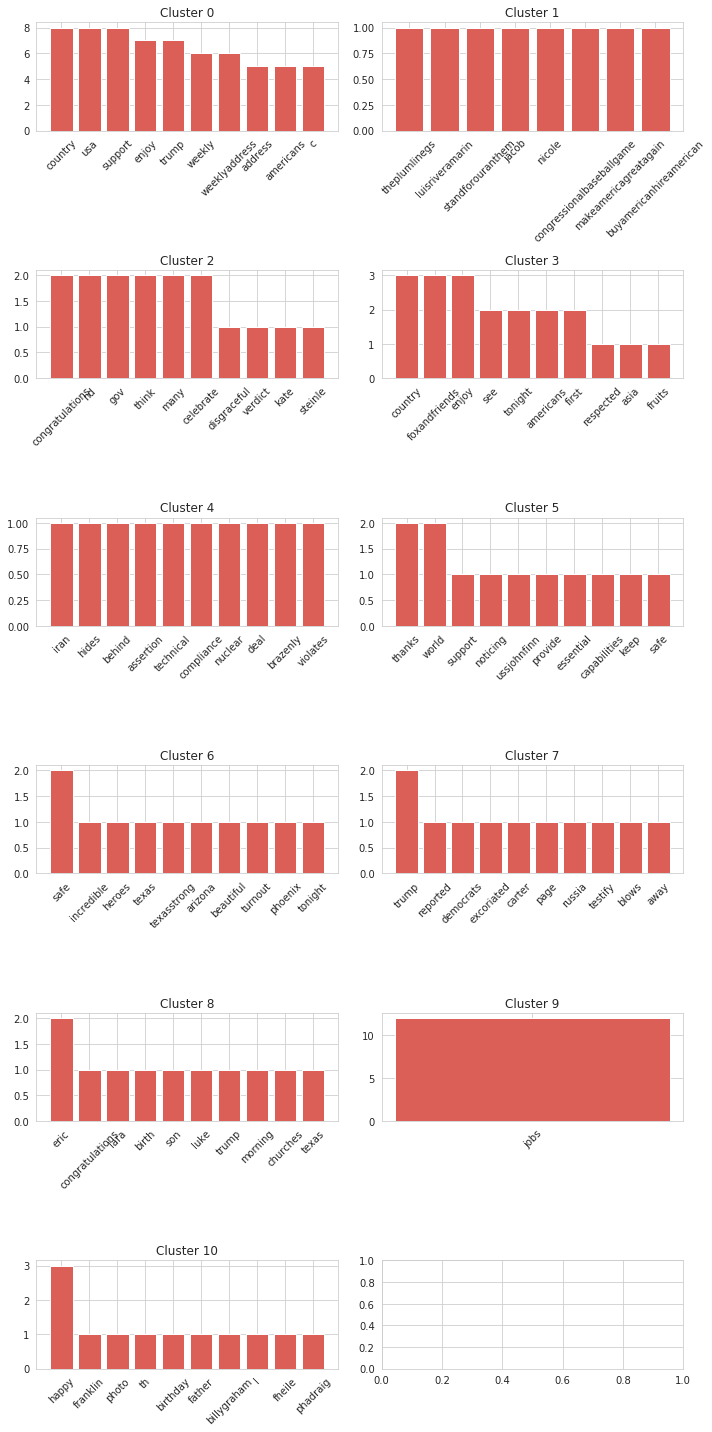

In [0]:
tweets = dataset['text'].iloc[ind]
tweets = tweets.reset_index(drop=True)
plot_frequency_clusters(n_clusters,pos_labels,tweets,n=10,figsize=(10,20))